# Introduction

This is a submission made for IEEE cs club application's AI task.

The highlight of this submission is that I don't use any libraries like tensorflow or pytorch's autograd engine. Instead the neural network trained is using Nanograd, that's autograd engine that I have built. Alongside that, I also use custom implementation of optimizer SGD that's built for nanograd, and custom implementation of ce_loss function and relu!

With this we get the accuracy score of ~0.898 on validation set.


Though nanograd currently depends on pytorch, that's only because we leverage their tensors as computational backends i.e. to perform fast matrix multiplications and other matrix operations.


## Getting started


```bash
$ git clone https://github.com/IAmPara0x/nanograd
$ cd nanograd
```

* The notebook of interest is present in `./examples/fashion_mnist.ipynb`.
* Start that notebook using jupyter lab
* and then modify the `DATA_DIR` variable to point to the dataset folder.

In [1]:
import idx2numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import random
import pandas as pd

In [3]:
DATA_DIR = "./data/dataset_aiml_task"

In [4]:
images = idx2numpy.convert_from_file(f"{DATA_DIR}/images-idx3-ubyte")
labels = idx2numpy.convert_from_file(f"{DATA_DIR}/labels-idx1-ubyte")

In [5]:

def plot_fashion_images(images, labels, class_names, num_images=8):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

## Define some constants

In [6]:
IMG_HEIGHT = 28
IMG_WIDTH  = 28
SEED = 42

CLASS_NAMES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

CLASS_NAME_2_LABEL = {n: idx for idx, n in enumerate(CLASS_NAMES)}

In [7]:

# SEED for reproducibility
np.random.seed(SEED)

# EDA

* Let's Look at some images from the dataset

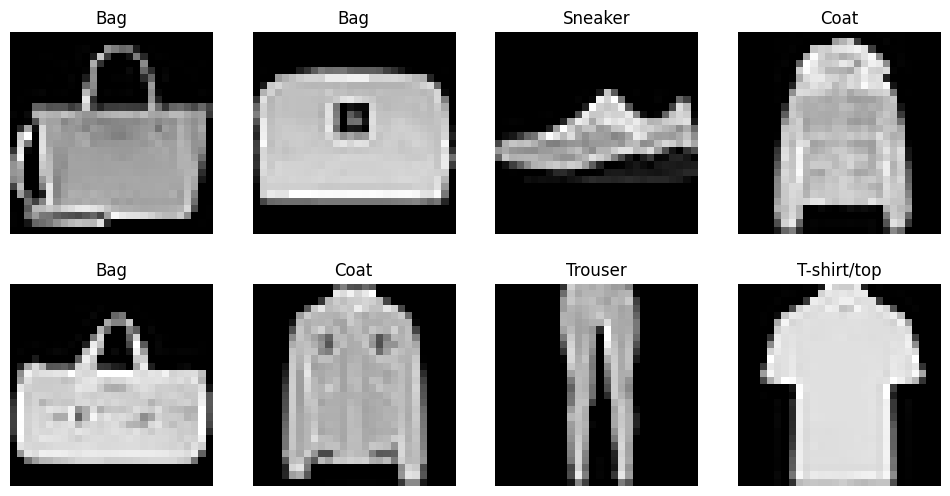

In [8]:
num_images = 8

sampled_idxs = np.random.choice(images.shape[0], num_images, replace=False)


plot_fashion_images(images[sampled_idxs], labels[sampled_idxs], CLASS_NAMES)


* Let's look at the labels available for each class in the dataset

/tmp/ipykernel_43166/1356036100.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=CLASS_NAMES, y=counts, palette="rocket")


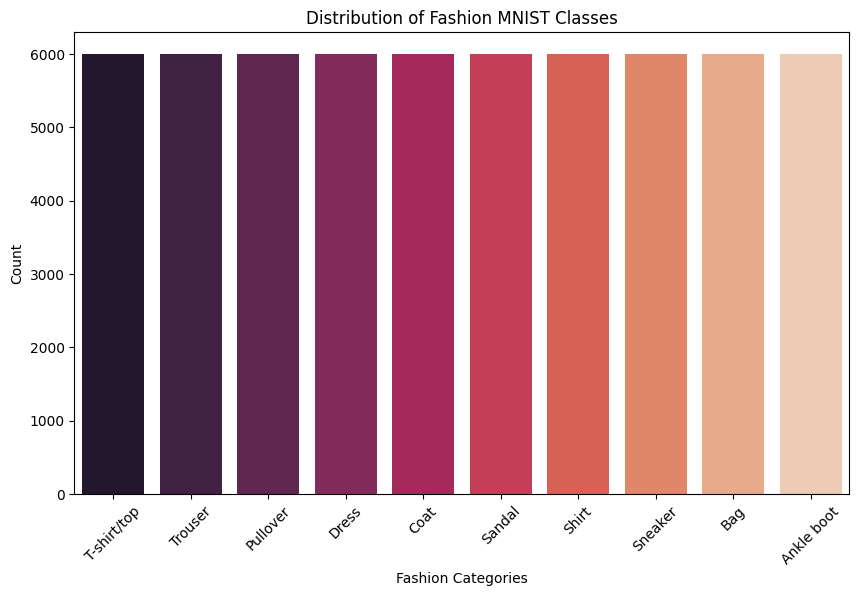

In [9]:


unique, counts = np.unique(labels, return_counts=True)


plt.figure(figsize=(10, 6))
sns.barplot(x=CLASS_NAMES, y=counts, palette="rocket")


plt.xlabel("Fashion Categories")
plt.ylabel("Count")
plt.title("Distribution of Fashion MNIST Classes")
plt.xticks(rotation=45)
plt.show()

* We can see that all the labels are equally present in the dataset

* Let's plot mean pixel intensities of each class sample and check their probability distribution

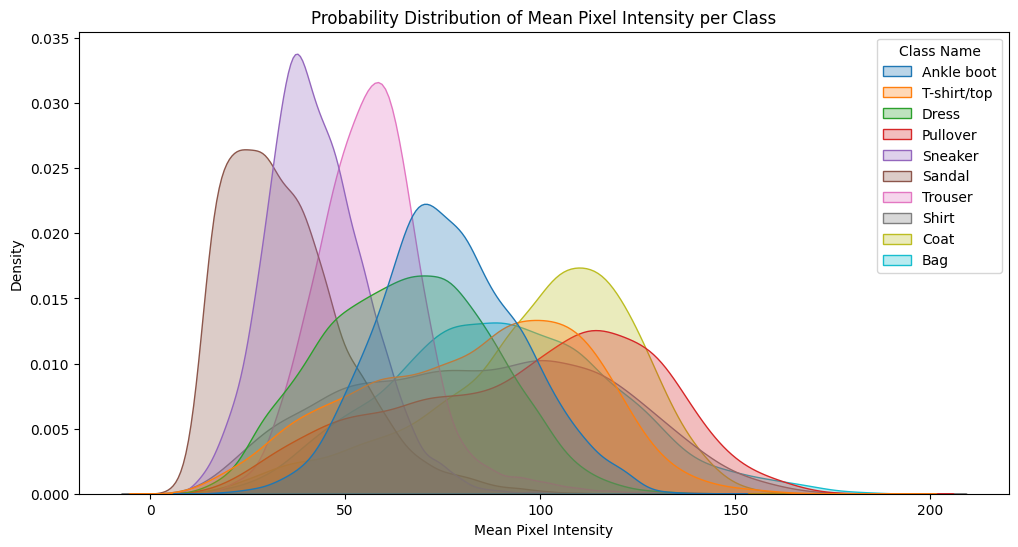

In [10]:


mean_intensities = images.mean(axis=(1, 2))


df = pd.DataFrame({"Mean Intensity": mean_intensities, "Label": labels})
df["Class Name"] = df["Label"].apply(lambda x: CLASS_NAMES[x])

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Mean Intensity", hue="Class Name", fill=True, common_norm=False, alpha=0.3)
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Density")
plt.title("Probability Distribution of Mean Pixel Intensity per Class")

plt.show()


* It seems like sandal has lowest mean pixel intensity.
* Pullover seems to have the highest mean pixel intensity.

The implies that Sandal may generally have less foreground pixels and Pullover have more foreground pixels.

Let's see if it's true

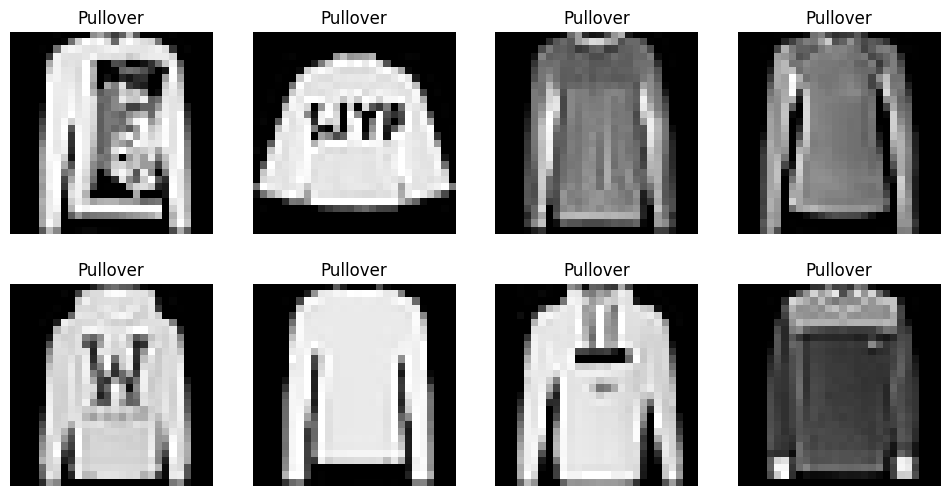

In [11]:

num_images = 8

sampled_idxs = np.random.choice(6000, num_images, replace=False)

plot_fashion_images((images[labels==CLASS_NAME_2_LABEL["Pullover"]])[sampled_idxs], (labels[labels==2])[sampled_idxs], CLASS_NAMES)

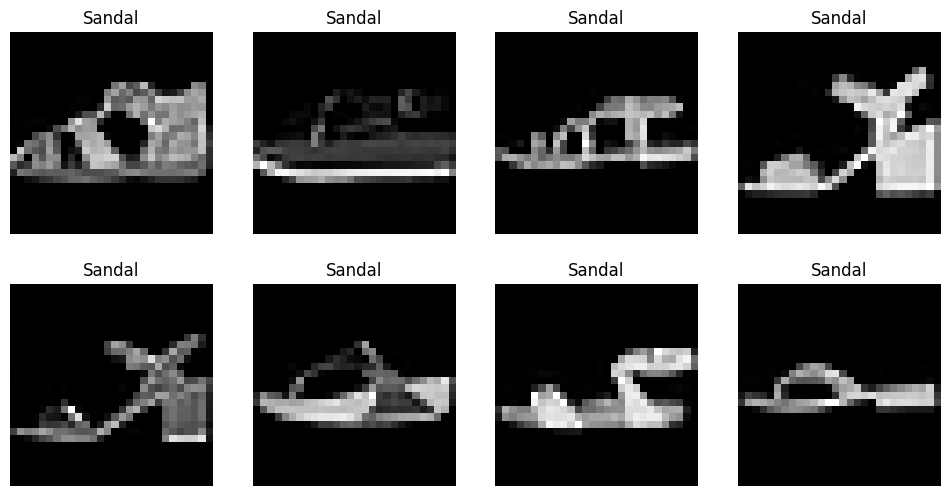

In [12]:


num_images = 8

sampled_idxs = np.random.choice(6000, num_images, replace=False)

plot_fashion_images((images[labels==CLASS_NAME_2_LABEL["Sandal"]])[sampled_idxs], (labels[labels==5])[sampled_idxs], CLASS_NAMES)

* Our inference was indeed correct that sandals have very less forground pixels and their intensities are not high compared to pullover which almost cover the whole image

# Training NN using Nanograd

In [13]:
import sys

sys.path.append("..")

In [14]:
from nanograd.autograd import Tensor
from nanograd.optim import SGD
from nanograd.utils import crossentropy_loss, softmax, uniform

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch

* Training Hyperparameters

In [15]:
DEVICE = "cpu"
EPOCHS = 24
BATCH_SIZE=64
HEIGHT=28
WIDTH=28
N_CLASSES = 10
TEST = False
TEST_SPLIT = 0.2


In [16]:
def init_model():

    N = HEIGHT * WIDTH
    scale = lambda f_in: (3 / f_in) ** 0.5

    w1 = Tensor(uniform(lower=-scale(N), upper=scale(N), shape=(N,N)), _test=TEST)
    b1 = Tensor(torch.zeros(N), _test=TEST)

    w2 = Tensor(uniform(lower=-scale(N), upper=scale(N), shape=(N,N)), _test=TEST)
    b2 = Tensor(torch.zeros(N), _test=TEST)

    w3 = Tensor(uniform(lower=-scale(N_CLASSES), upper=scale(N_CLASSES), shape=(N,N_CLASSES)), _test=TEST)
    b3 = Tensor(torch.zeros(N_CLASSES), _test=TEST)

    def model(x,y):

        h1 = (x.matmul(w1) + b1).relu()
        h2 = (h1.matmul(w2) + b2).relu()
        logits = h2.matmul(w3) + b3
        probs = softmax(logits, 1)
        loss = crossentropy_loss(y, probs, N_CLASSES)
        return (loss, probs)

    return model, dict(w1=w1,b1=b1,w2=w2,b2=b2,w3=w3,b3=b3)


In [17]:
model,params = init_model()
optimizer = SGD([*params.values()], lr=2e-2)

In [18]:
images,labels = np.array(images) / 255.0,np.array(labels)
X_train,X_test, y_train, y_test  = train_test_split(images,labels,test_size=TEST_SPLIT,random_state=SEED, shuffle=True)

In [19]:


training_loss = []
validation_loss = []
accuracy = []

for epoch in range(EPOCHS):

    print("\n")
    epoch_training_loss = []
    epoch_validation_loss = []
    epoch_accuracy = []


    for batch_idx in (pbar := tqdm(range(0, len(X_train), BATCH_SIZE))):

        optimizer.zero_grad()
        x = Tensor(X_train[batch_idx: batch_idx + BATCH_SIZE].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32), requires_grad=False, _test=TEST)
        y = y_train[batch_idx: batch_idx + BATCH_SIZE]

        (loss, _) = model(x,y.tolist())
        loss.backward()
        optimizer.step()

        epoch_training_loss.append(float(loss.value))

        pbar.set_description(f"epoch: {epoch}, average_training_loss: {np.mean(epoch_training_loss):.4f}, loss: {loss.value.item():.4f}")

    training_loss.append(sum(epoch_training_loss) / len(epoch_training_loss))

    for batch_idx in (pbar := tqdm(range(0, len(X_test), BATCH_SIZE))):

        x = Tensor(X_test[batch_idx: batch_idx + BATCH_SIZE].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32))
        y = y_test[batch_idx: batch_idx + BATCH_SIZE]

        (loss, probs) = model(x, y.tolist())
        epoch_validation_loss.append(float(loss.value))

        preds = probs.value.argmax(dim=-1).numpy()
        acc = accuracy_score(y, preds)
        epoch_accuracy.append(acc)

        pbar.set_description(f"epoch: {epoch}, average_validation_loss: {np.mean(epoch_validation_loss):.4f}, accuracy: {np.mean(epoch_accuracy):.4f}")

    validation_loss.append(sum(epoch_validation_loss) / len(epoch_validation_loss))
    accuracy.append(np.mean(epoch_accuracy))


epoch: 0, average_training_loss: 0.5380, loss: 0.3978: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 342.00it/s]
epoch: 0, average_validation_loss: 0.4051, accuracy: 0.8580: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 859.81it/s]


epoch: 1, average_training_loss: 0.3789, loss: 0.3419: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 336.97it/s]
epoch: 1, average_validation_loss: 0.3647, accuracy: 0.8708: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 869.72it/s]


epoch: 2, average_training_loss: 0.3361, loss: 0.2981: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 329.10it/s]
epoch: 2, average_validation_loss: 0.3458, accuracy: 0.8761: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 889.37it/s]


epoch: 3, average_training_loss: 0.3078, loss: 0.2913: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 340.64it/s]
epoch: 3, average_validation_loss: 0.3345, accuracy: 0.8812: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 873.30it/s]


epoch: 4, average_training_loss: 0.2858, loss: 0.2654: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 327.60it/s]
epoch: 4, average_validation_loss: 0.3262, accuracy: 0.8829: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 898.75it/s]


epoch: 5, average_training_loss: 0.2684, loss: 0.2571: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 343.95it/s]
epoch: 5, average_validation_loss: 0.3198, accuracy: 0.8850: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 886.39it/s]


epoch: 6, average_training_loss: 0.2532, loss: 0.2413: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 342.22it/s]
epoch: 6, average_validation_loss: 0.3144, accuracy: 0.8865: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 625.83it/s]


epoch: 7, average_training_loss: 0.2396, loss: 0.2370: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 343.31it/s]
epoch: 7, average_validation_loss: 0.3104, accuracy: 0.8881: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 889.54it/s]


epoch: 8, average_training_loss: 0.2276, loss: 0.2173: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 339.67it/s]
epoch: 8, average_validation_loss: 0.3086, accuracy: 0.8893: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 886.39it/s]


epoch: 9, average_training_loss: 0.2165, loss: 0.2110: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 329.32it/s]
epoch: 9, average_validation_loss: 0.3064, accuracy: 0.8896: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 882.24it/s]


epoch: 10, average_training_loss: 0.2067, loss: 0.2077: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 340.84it/s]
epoch: 10, average_validation_loss: 0.3030, accuracy: 0.8912: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 883.23it/s]


epoch: 11, average_training_loss: 0.1974, loss: 0.1963: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 327.99it/s]
epoch: 11, average_validation_loss: 0.3016, accuracy: 0.8911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 891.04it/s]


epoch: 12, average_training_loss: 0.1888, loss: 0.1908: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 342.17it/s]
epoch: 12, average_validation_loss: 0.3007, accuracy: 0.8923: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 882.76it/s]


epoch: 13, average_training_loss: 0.1809, loss: 0.1824: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 327.89it/s]
epoch: 13, average_validation_loss: 0.2993, accuracy: 0.8926: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 897.87it/s]


epoch: 14, average_training_loss: 0.1734, loss: 0.1712: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 340.34it/s]
epoch: 14, average_validation_loss: 0.2991, accuracy: 0.8938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 888.41it/s]


epoch: 15, average_training_loss: 0.1663, loss: 0.1643: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 341.52it/s]
epoch: 15, average_validation_loss: 0.2988, accuracy: 0.8939: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 868.58it/s]


epoch: 16, average_training_loss: 0.1596, loss: 0.1566: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 324.19it/s]
epoch: 16, average_validation_loss: 0.2985, accuracy: 0.8945: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 880.09it/s]


epoch: 17, average_training_loss: 0.1532, loss: 0.1547: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 340.00it/s]
epoch: 17, average_validation_loss: 0.2979, accuracy: 0.8944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 883.78it/s]


epoch: 18, average_training_loss: 0.1473, loss: 0.1453: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 327.78it/s]
epoch: 18, average_validation_loss: 0.2981, accuracy: 0.8949: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 885.57it/s]


epoch: 19, average_training_loss: 0.1415, loss: 0.1411: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 339.45it/s]
epoch: 19, average_validation_loss: 0.2988, accuracy: 0.8953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 876.00it/s]


epoch: 20, average_training_loss: 0.1360, loss: 0.1388: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 327.90it/s]
epoch: 20, average_validation_loss: 0.2997, accuracy: 0.8944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 887.41it/s]


epoch: 21, average_training_loss: 0.1307, loss: 0.1331: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 339.95it/s]
epoch: 21, average_validation_loss: 0.3012, accuracy: 0.8953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 876.34it/s]


epoch: 22, average_training_loss: 0.1260, loss: 0.1284: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 339.67it/s]
epoch: 22, average_validation_loss: 0.3021, accuracy: 0.8953: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 624.15it/s]


epoch: 23, average_training_loss: 0.1211, loss: 0.1220: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:02<00:00, 340.06it/s]
epoch: 23, average_validation_loss: 0.3035, accuracy: 0.8959: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 886.29it/s]


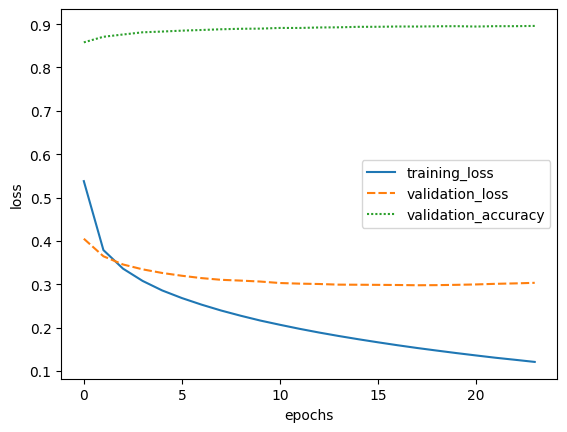

In [24]:

df = pd.DataFrame({"training_loss": training_loss, "validation_loss": validation_loss, "validation_accuracy": accuracy})
sns.lineplot(data=df)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

* Now let's check what our Neural Network has learnt

In [21]:
N = 10
x = Tensor(X_test[:N].reshape(-1, IMG_HEIGHT * IMG_WIDTH).astype(np.float32))
y = y_test[:N]

(loss, probs) = model(x, y.tolist())
preds = probs.value.argmax(dim=-1).squeeze()

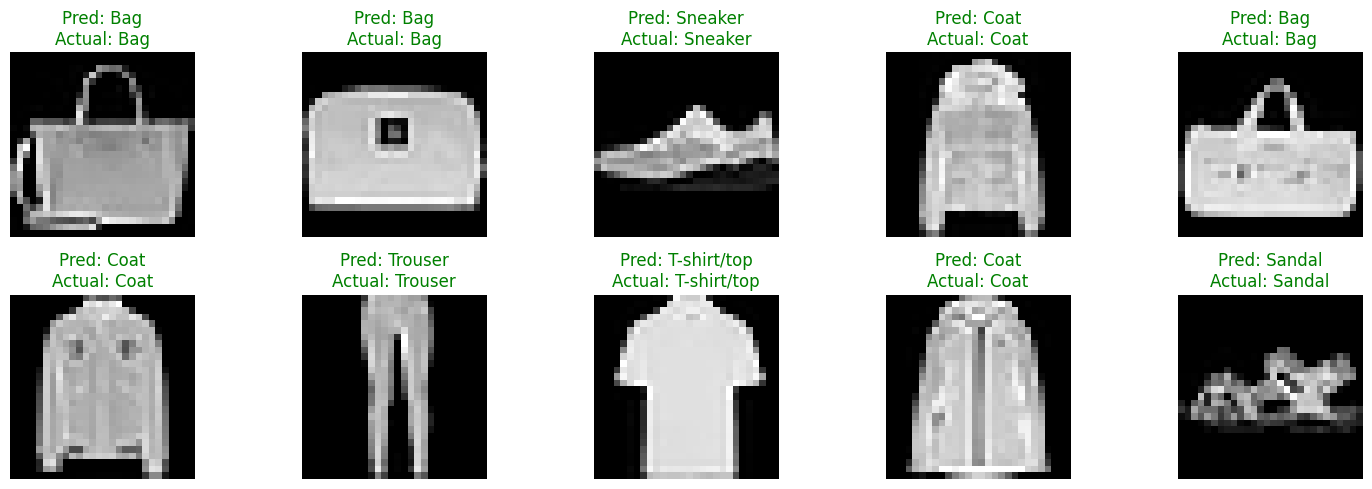

In [22]:

# Plot the images with predicted and actual labels
plt.figure(figsize=(15, 5))
for idx in range(N):
    plt.subplot(2, 5, idx + 1)
    plt.imshow(X_test[idx], cmap="gray")
    plt.axis("off")
    title = f"Pred: {CLASS_NAMES[preds[idx]]}\nActual: {CLASS_NAMES[y[idx]]}"
    plt.title(title, color="green" if preds[idx] == y[idx] else "red")

plt.tight_layout()
plt.show()


* Wow all/most of the images has been be classified successfully !!